# Etivity 4: _Classification_
**Student Name**: _Sean Morrissey_

**Student ID**: _17222761_

The aim of this etivity is to introduce predicitve data analytic processes through classification. In this etivity multiple classification models/classifiers will be trained and evaluated on the seeds dataset. In this etivity we will:
- Formulate a binary classification problem to solve by transforming our `type` attribute.
- Train and evaluate **SVM** and **Random Forest** classifiers
- Also train and evaluate a **KNN** model
- Explore the optimal parameters for each model
- Produce metrics for each model such as **accuracy**, **precision**, **recall** and **F1-score**
- Evaluate the models based on these metrics as well as their **ROC** and the **AUC** they produce based on their **TP** and **FP** rates

## Part 1: Imports and EDA

In [107]:
# Import required packages
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [108]:
# Read in the dataset
df = pd.read_csv("./seeds.csv")

# Check the first five rows of the dataframe
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [109]:
# See the total count for each type of seed in the dataset
df['type'].value_counts()

3    70
2    70
1    70
Name: type, dtype: int64

As we can see from the above cell there is 3 different types of seeds, with each type of seed having an equal ration (33.3..%) to the other seeds. Having 3 types of seeds here clearly does not conform to a binary classification. Later on we will transform this `type` attribute so that there is only two different values in **value_counts()** and so it will be binary.

In [110]:
# Check for missing values
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

There are no missing values. Let's check the boxplots of the numerical columns for outliers.

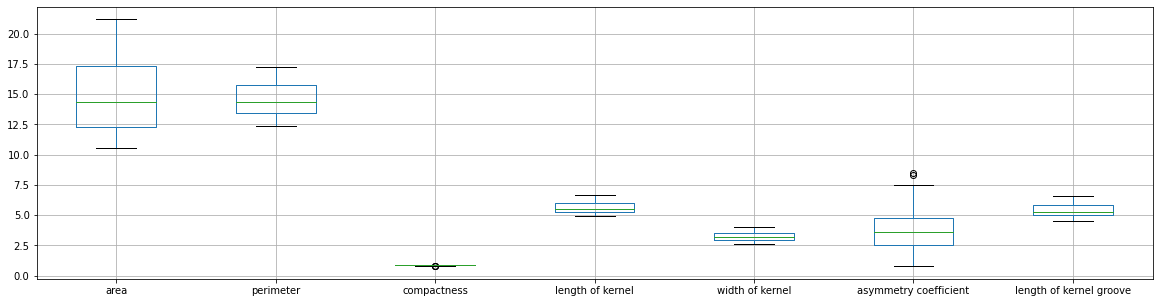

In [111]:
df.loc[:,'area':'length of kernel groove'].boxplot(figsize=(20,5))
plt.show()

The `compactness` and `asymmetry coefficient` attributes both contain outliers albeit a small amount. We will use the **Robustscaler** on these attributes due to this. For the rest of the attributes we will use the **Standardscaler**.

## Part 2: Transformation to Binary Classification

As mentioned previously, the dataset is not suited for a binary classification problem and needs to be transformed. As the `type` attribute is the classification variable (the variable which we would like our classifiers to predict) this attribute needs to be transformed.

The binary classification problem I am proposing is to guess whether a seed is of `type` **1** or not. This would satisfy binary classification as there would be only two possible outcomes, a seed is of `type` **1** or the seed is not of `type` **1**. 

Breaking this down into a binary classification problem allows for better results in identifying this one class. A real world example of this could be seen in a seed processing plant where seeds need to be put into different packages. The **cost of misclassifying examples** in this use case could result in angry customers who receive the wrong product and so it is important for us to correctly identify `type` **1** seeds so that customers who expect that seed indeed do get it.

In [112]:
df.loc[df.type == 2, "type"] = 0
df.loc[df.type == 3, "type"] = 0
df['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

As seeds of `type` **1** are already = 1, we do not need to do anything to them. For seeds of `type` **2** and **3** we set them to be **0**. We now have 70 data points in the minority class and 140 data points in the majority class.

## Part 3: Data Prepartaion

In [113]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['asymmetry coefficient', 'compactness']
names_no_outliers = list(set(names_all) - set(names_outliers))

We create two lists:
- The first list contains the columns which contain outliers
- The second list contains the columns without outliers

For the columns with outliers we will apply the **RobustScaler** and a log function, for the columns without outliers we will apply the **StandardScaler**.

In [114]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

The above class is created for use in the preprocessing pipeline to put the names of the columns back together after they have been split into training and test datasets. We need this as we need to apply preperation strategies to the two groups of columns.

In [115]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

The above class simply selects a group of columns.

In [116]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

We create our preprocess pipeline which applies the StandardScaler to the columns with no outliers and applies the log and RobustScaler to the columns with outliers. It then Unions the two together.

In [117]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

We split the target attribute which is `type` away from the rest of the predictors. 

Then we split both the x and y dataframes into **test** and **training** sets. The training sets contains **80%** of the data while the test sets contain the remaining **20%**. We also shuffle the dataset since all of the 1's follow each other but we use stratify so that the amount of both classes remain proportionate in both the test and training sets.

## Part 4: Exploration of Parameters and Training of Models

In [118]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly'],
    'svm__degree': [2, 3, 4]
}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.958:
Best parameters:  {'svm__C': 100, 'svm__degree': 2, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


We next train our SVM classifier with the training set. We use grid search to find the best parameters which will produce the best score for the classifier. We create another pipeline which combines the preprocessing pipeline and the SVM classifier.

The best parameters were:
- C = 10: C is the regularization parameter.
- Degree = 2: Degree is the degree of the polynomial kernel function
- Gamma = 0.01: Gamma is the kernel coefficient
- Kernel = rbf: Kernel specifies the kernel type to be used in the algorithm.

In [119]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10, 20, 30, 40, 50],
    'rf__max_depth': [2, 4, 6, 8],
    'rf__bootstrap': [True, False]
}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.917:
Best parameters:  {'rf__bootstrap': True, 'rf__max_depth': 8, 'rf__n_estimators': 20}


We next train our Random Forest classifier with the training set. We use grid search to find the best parameters which will produce the best score for the classifier. We create another pipeline which combines the preprocessing pipeline and the Random Forest classifier.

The best parameters were:
- N_estimators = 30: This is the number of trees in the forest
- Max_depth = 8: This specifies the maximum depth of the tree
- Bootstrap = False: This specifies whether bootstap samples are to be used when building the trees. If its false the whole dataset is used to build the tree.

### Part 4.1: Training Model using KNN Classification Algorithm

The alternative classification algorithm implemented in this etivity is KNN or K Nearest Neighbors Classification. This algorithm works by computing classification from a simple majority vote of the nearest neighbors of each point. A query point is assigned to the data class which has the most representatives within the nearest neighbors of the point.

In [120]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', KNeighborsClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'knn__n_neighbors' : [2, 4, 6, 8],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [20, 25, 30, 35, 40],
    'knn__p': [1, 2]
}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.929:
Best parameters:  {'knn__algorithm': 'auto', 'knn__leaf_size': 20, 'knn__n_neighbors': 2, 'knn__p': 2, 'knn__weights': 'uniform'}


We next train our KNN classifier with the training set. We use grid search to find the best parameters which will produce the best score for the classifier. We create another pipeline which combines the preprocessing pipeline and the KNN classifier.

The best parameters were:
- N_neighbors = 2: This is the number of neighbours to use i.e. K
- Weights = distance: This is the weight function to be used in prediction.
- Algorithm = auto: This is the algorithm used to compute the nearest neighbour.
- Leaf_size = 20: This is the leaf size passed to the algorithm above and can affect the speed and memory of the classifier.
- P = 2: This is the power parameter for the Minkowski metric. i.e. manhattan distance or euclidean distance

## Part 5: Apply Classifiers to Test Set

In [121]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

We create a false positive rate scale between 0 and 1 with 100 equally spaced false positive rate values between 0 and 1.

In [122]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

The above function evaluates the models found by the grid search for SVM Random Forest and KNN.

In [123]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)

RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, KNN_best_model)

We can now evaluate the best models found by grid search on the test dataset and compare their results to choose the best classifier for our problem.

The metrics which we will be evaluating our model from the test set are:
- Accuracy
- Precision
- Recall
- F1-score
- True positive rate
- AUC (Area under the Receiver operator characteristic curve)

## Part 6: Evaluating Results

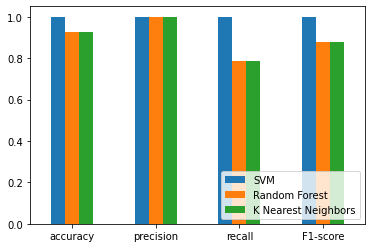

In [124]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'K Nearest Neighbors': KNN_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

From the above barcharts we can see that:
- SVM is the classifier with the highest scores for each of the four metrics.
- SVM has a higher accuracy than Random Forest and KNN. This is due to SVM having higher true positives and true negatives and thus having less false positives and false negatives.
- All 3 have the same precision. This means that the true positve rate they all either have the same tp and fp or they have the same ratio of tp to fp.
- SVM by far has the highest recall meaning it has less fn (false negatives) than the others.
- SVM again has the highest f1-score meaning it either has more true positives than the others or less false positives or false negatives than the others

From the above barcharts we can see that SVM is clearly the best classifier as it outperforms the rest in 3 out of the 4 metrics.

KNN compared to the rest is worse than SVM in this case but the above barcharts make it look like KNN and Random forest are tied in all of the metrics.

*Note that this conclusion is true for this run. If the code is executed again results may vary*

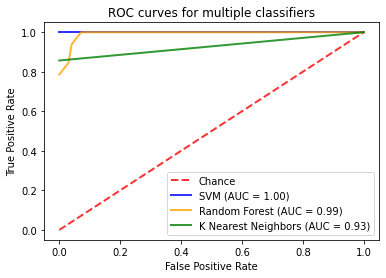

In [125]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr[0,:], lw=2, color='green', label='K Nearest Neighbors (AUC = %0.2f)' % (KNN_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

The AUC of the ROC curve also backs up our previous statement that SVM is the best classifier algorithm for this binary classification problem. All of the models perform exceptionaly well and outperform chance/random classification hands down.

SVM clearly outperforms the rest and has the highest AUC. Random forest is only marginally behind SVM in terms of AUC. As mentioned previously Random Forest and KNN seemed to be similar in terms of accuracy, precision, recall and F1-score but the above plot shows that KNN in fact has the worst AUC and is the worst of the 3 classifiers.

*Note that this conclusion is true for this run. If the code is executed again results may vary*


## Part 7: Training a Final Model

In [126]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

Finally, we can train an SVM model with all data we have, assuming that the more data we have the better the model.

In [127]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

We can also store this model on disk.